<a href="https://colab.research.google.com/github/Laimo64/Laimo64/blob/main/AI_CW_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Small dataset
!gdown --fuzzy https://drive.google.com/file/d/1y8OFnIFYC_b_WIexKSog732_L78Pegxa/view?usp=drive_link
!unzip -q brain_small.zip


Downloading...
From (original): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa
From (redirected): https://drive.google.com/uc?id=1y8OFnIFYC_b_WIexKSog732_L78Pegxa&confirm=t&uuid=e85b1dfe-732f-44b3-8a56-31fb9f946f72
To: /content/brain_small.zip
100% 119M/119M [00:00<00:00, 135MB/s] 


In [10]:
# Full dataset
!gdown --fuzzy https://drive.google.com/file/d/1eSU-or72yvc3btOhfLO-edux5VBe_TrX/view?usp=sharing
!unzip -q brain.zip

Downloading...
From (original): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX
From (redirected): https://drive.google.com/uc?id=1eSU-or72yvc3btOhfLO-edux5VBe_TrX&confirm=t&uuid=1e8c1ff1-7f3a-45d7-83c0-beb0ecc889a6
To: /content/brain.zip
100% 4.97G/4.97G [01:23<00:00, 59.6MB/s]


In [11]:
from sklearn.model_selection import train_test_split
import shutil
import os

data_path = "/content/brain"
output_root = "/content/split"  # 輸出目錄
# data_path = "/content/small"
# output_root = "/content/split"  # 輸出目錄

# 創建輸出資料夾
os.makedirs(output_root, exist_ok=True)
os.makedirs(os.path.join(output_root, "train"), exist_ok=True)
os.makedirs(os.path.join(output_root, "validation"), exist_ok=True)
os.makedirs(os.path.join(output_root, "test"), exist_ok=True)

# 獲取所有樣本資料夾名稱
samples = [name for name in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, name))]

# 按照 70:15:15 的比例分割
train_samples, test_samples = train_test_split(samples, test_size=0.3, random_state=42)
validation_samples, test_samples = train_test_split(test_samples, test_size=0.5, random_state=42)

print(f"Total samples: {len(samples)}")
print(f"Train samples: {len(train_samples)}, Validation samples: {len(validation_samples)}, Test samples: {len(test_samples)}")

# 定義拷貝函數
def move_samples(samples, output_dir):
    for sample in samples:
        src_path = os.path.join(data_path, sample)  # 原始路徑
        dst_path = os.path.join(output_dir, sample)  # 目標路徑
        if os.path.exists(dst_path):
            print(f"Sample {sample} already exists in {output_dir}, skipping.")
            continue
        shutil.copytree(src_path, dst_path)  # 拷貝整個資料夾

# 將樣本移動到各自的資料夾
move_samples(train_samples, os.path.join(output_root, "train"))
move_samples(validation_samples, os.path.join(output_root, "validation"))
move_samples(test_samples, os.path.join(output_root, "test"))

print("Data split and moved successfully!")


Total samples: 181
Train samples: 126, Validation samples: 27, Test samples: 28
Sample 1BA012 already exists in /content/split/train, skipping.
Sample 1BA005 already exists in /content/split/train, skipping.
Sample 1BA014 already exists in /content/split/validation, skipping.
Data split and moved successfully!


In [9]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
from scipy.ndimage import zoom

class MRCTDataset(Dataset):
    def __init__(self, data_dir, target_size=(128, 128, 128)):
        """
        初始化數據集
        Args:
            data_dir (str): MRI 和 CT 數據的根目錄。
            target_size (tuple): 將 MRI 和 CT 影像調整為的固定尺寸。
        """
        self.data_dir = data_dir
        self.target_size = target_size
        self.samples = [
            os.path.join(root)
            for root, _, files in os.walk(data_dir)
            if "mr.nii.gz" in files and "ct.nii.gz" in files
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        根據索引返回一組 MR 和 CT 影像。
        Args:
            idx (int): 數據的索引。
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: MR 和 CT 的張量形式。
        """
        sample_path = self.samples[idx]

        # 加載 MRI 和 CT 影像
        mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
        ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

        # Z-score 標準化
        mr = self._normalize(mr)
        ct = self._normalize(ct)

        # 調整或填充影像大小
        mr = self._resize_or_pad(mr, self.target_size)
        ct = self._resize_or_pad(ct, self.target_size)

        # 轉換為 PyTorch 張量並增加通道維度
        mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)
        ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)  # (1, D, H, W)

        return mr, ct

    def _normalize(self, image):
        """
        Z-score 標準化影像數據。
        Args:
            image (np.ndarray): 輸入影像。
        Returns:
            np.ndarray: 標準化的影像。
        """
        if np.std(image) != 0:
            return (image - np.mean(image)) / np.std(image)
        else:
            return image

    def _resize_or_pad(self, image, desired_shape):
        """
        調整影像大小或填充至固定大小。
        Args:
            image (np.ndarray): 輸入影像。
            desired_shape (tuple): 目標大小。
        Returns:
            np.ndarray: 調整或填充後的影像。
        """
        current_shape = image.shape
        scale = [d / c for d, c in zip(desired_shape, current_shape)]
        resized_image = zoom(image, scale, order=1)  # 調整大小

        # 填充影像至目標大小
        padded_image = np.zeros(desired_shape, dtype=resized_image.dtype)
        pad_slices = tuple(slice(0, min(dim, resized_image.shape[i])) for i, dim in enumerate(desired_shape))
        padded_image[pad_slices] = resized_image[:desired_shape[0], :desired_shape[1], :desired_shape[2]]

        return padded_image


EarlyStopping & Visualization

In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class EarlyStopping:
    def __init__(self, patience=5, verbose=True, delta=0.00005, path="checkpoint.pt"):
        """
        Args:
            patience (int): 容忍驗證損失未改善的次數 (default: 5)
            verbose (bool): 是否打印相關資訊 (default: False)
            delta (float): 最小改善幅度，只有超過此值才算改善 (default: 0)
            path (str): 模型權重保存路徑 (default: "checkpoint.pt")
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")

    def __call__(self, val_loss, model):
        # 計算當前得分（驗證損失的負值，因為越小越好）
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """保存當前模型權重"""
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


def visualize_results(input_image, target_image, predicted_image, epoch, idx):
    """
    視覺化輸入影像、目標影像與預測影像
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 輸入影像
    axes[0].imshow(input_image[0, 0, :, :, input_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Input (MR)")
    axes[0].axis("off")

    # 目標影像3
    axes[1].imshow(target_image[0, 0, :, :, target_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("Target (CT)")
    axes[1].axis("off")

    # 預測影像
    axes[2].imshow(predicted_image[0, 0, :, :, predicted_image.shape[4] // 2].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("Prediction (Generated CT)")
    axes[2].axis("off")

    plt.suptitle(f"Epoch {epoch}, Batch {idx}")
    plt.show()

GAN model

In [6]:
# import os
# import nibabel as nib
# import numpy as np
# import torch
# from torch import nn, optim
# from torch.utils.data import Dataset, DataLoader
# from torchvision.transforms import Normalize
# from scipy.ndimage import zoom


# # Data preprocessing and dataset class
# class MRCTDataset(Dataset):
#     def __init__(self, data_dir, target_size=(128, 128, 128)):
#         self.data_dir = data_dir
#         self.target_size = target_size
#         self.samples = [
#             os.path.join(root)
#             for root, _, files in os.walk(data_dir)
#             if "mr.nii.gz" in files and "ct.nii.gz" in files and "mask.nii.gz" in files
#         ]

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         sample_path = self.samples[idx]
#         mr = nib.load(os.path.join(sample_path, "mr.nii.gz")).get_fdata()
#         ct = nib.load(os.path.join(sample_path, "ct.nii.gz")).get_fdata()

#         mr = self._normalize(mr)
#         ct = self._normalize(ct)

#         mr = self._resize_or_pad(mr, self.target_size)
#         ct = self._resize_or_pad(ct, self.target_size)

#         mr = torch.tensor(mr, dtype=torch.float32).unsqueeze(0)
#         ct = torch.tensor(ct, dtype=torch.float32).unsqueeze(0)

#         return mr, ct

#     def _normalize(self, image):
#         return (image - np.mean(image)) / (np.std(image) + 1e-5)

#     def _resize_or_pad(self, image, target_size):
#         zoom_factors = [t / s for t, s in zip(target_size, image.shape)]
#         return zoom(image, zoom_factors, order=1)

# # Generator and Discriminator Networks
# class Generator(nn.Module):   # to transform MR to CT using 3D CNN
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(128),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(64),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose3d(64, 1, kernel_size=4, stride=2, padding=1),
#             nn.Tanh()   # 使範圍在[-1, 1]
#         )

#     def forward(self, x):
#         return self.model(x)

# class Discriminator(nn.Module):  # to tell whether the input image is the ground truth from the dataset or generated by the generator
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
#             nn.BatchNorm3d(128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv3d(128, 1, kernel_size=4, stride=2, padding=1),
#             nn.Sigmoid()       # 使範圍在[0, 1] 希望判斷真實影像時越接近1，希望判斷生成影像時越接近0
#         )

#     def forward(self, x):
#         return self.model(x)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Swin Transformer Block (簡化版，適用於3D)
class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_size):
        super(SwinTransformerBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.fc = nn.Linear(dim, dim)
        self.window_size = input_size // 4  # 分割窗口，根據3D的尺寸調整

    def forward(self, x):
        b, c, d, h, w = x.shape  # 3D 輸入
        x = x.view(b, -1, c)  # 展平為序列
        x = self.norm(x)
        x = self.fc(x)
        return x.view(b, c, d, h, w)  # 還原為 3D

# MSEP 網路
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder 部分
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),  # 使用3D卷積
            nn.ReLU()
        )
        # Skip 連接部分 + RDSformer
        self.skip = SwinTransformerBlock(128, input_size=160)
        # Decoder 部分
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1),  # 使用3D反卷積
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=1, padding=1)  # 使用3D反卷積
        )

    def forward(self, x):
        enc = self.encoder(x)
        skip = self.skip(enc)  # 加入 skip connection
        dec = self.decoder(skip)
        return dec

# Initialize model
model = Generator()

# Test the model with dummy data (e.g., [Batch Size, Channel, Depth, Height, Width])
dummy_input = torch.randn(1, 1, 128, 128, 128)  # 假設數據大小是 [1, 1, 128, 128, 128]
output = model(dummy_input)

print("Output shape:", output.shape)  # 應該返回符合預期的 3D 輸出

class Discriminator(nn.Module):  # to tell whether the input image is the ground truth from the dataset or generated by the generator
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()       # 使範圍在[0, 1] 希望判斷真實影像時越接近1，希望判斷生成影像時越接近0
        )

    def forward(self, x):
        return self.model(x)

Output shape: torch.Size([1, 1, 128, 128, 128])


Checkpoint

In [7]:
# def save_checkpoint(self, val_loss, model):
#     # 儲存模型和優化器狀態
#     torch.save({
#         'epoch': epoch,  # 當前 epoch
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'val_loss': val_loss,
#     }, self.path)
#     print(f"Checkpoint saved at {self.path}")

# def load_checkpoint(model, optimizer, path="checkpoint.pt"):
#     checkpoint = torch.load(path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     val_loss = checkpoint['val_loss']
#     print(f"Checkpoint loaded from {path}")
#     return model, optimizer, epoch, val_loss


Epoch [1/10], Step [1/63], D Loss: 0.1446, G Loss: 0.1544
Epoch [1/10], Step [11/63], D Loss: 0.0748, G Loss: 0.2283
Epoch [1/10], Step [21/63], D Loss: 0.0881, G Loss: 0.2542
Epoch [1/10], Step [31/63], D Loss: 0.0436, G Loss: 0.3261
Epoch [1/10], Step [41/63], D Loss: 0.0532, G Loss: 0.3577
Epoch [1/10], Step [51/63], D Loss: 0.0173, G Loss: 0.4057
Epoch [1/10], Step [61/63], D Loss: 0.0091, G Loss: 0.4261


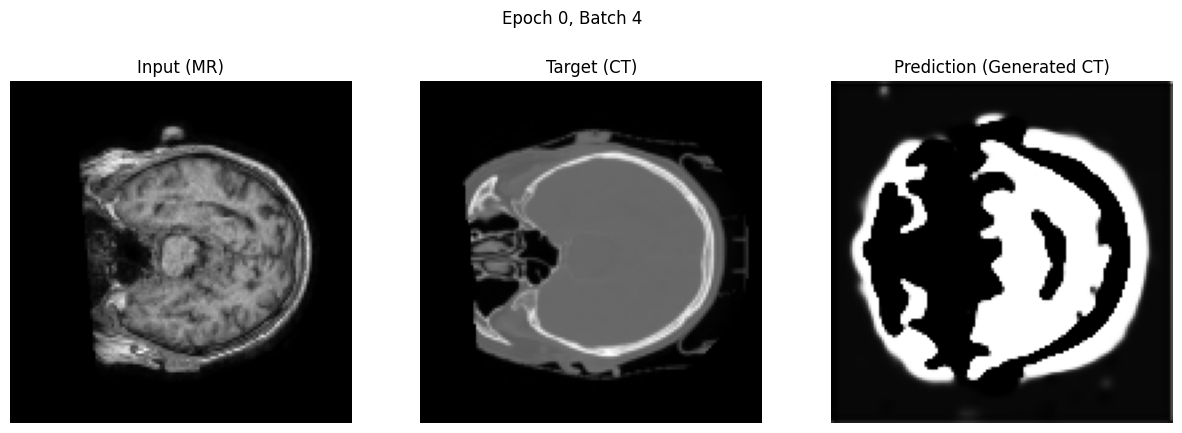

Epoch 1/10, Avg Validation Loss: 4648.4911, SSIM: -0.0000
Validation loss decreased (inf --> 4649.491079). Saving model...
Epoch [2/10], Step [1/63], D Loss: 0.0102, G Loss: 0.4148
Epoch [2/10], Step [11/63], D Loss: 0.0044, G Loss: 0.4432
Epoch [2/10], Step [21/63], D Loss: 0.0033, G Loss: 0.4440
Epoch [2/10], Step [31/63], D Loss: 0.0035, G Loss: 0.4480
Epoch [2/10], Step [41/63], D Loss: 0.0018, G Loss: 0.4612
Epoch [2/10], Step [51/63], D Loss: 0.0011, G Loss: 0.4600
Epoch [2/10], Step [61/63], D Loss: 0.0007, G Loss: 0.4663


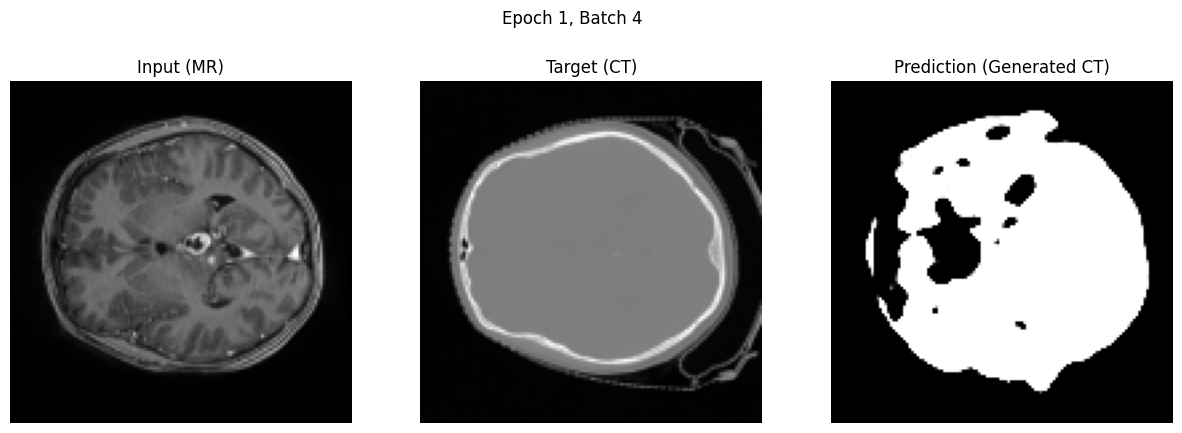

Epoch 2/10, Avg Validation Loss: 11053.7863, SSIM: -0.0000
EarlyStopping counter: 1 out of 5
Epoch [3/10], Step [1/63], D Loss: 0.0006, G Loss: 0.4721
Epoch [3/10], Step [11/63], D Loss: 0.0008, G Loss: 0.4755
Epoch [3/10], Step [21/63], D Loss: 0.0003, G Loss: 0.4770
Epoch [3/10], Step [31/63], D Loss: 0.0003, G Loss: 0.4783
Epoch [3/10], Step [41/63], D Loss: 0.0003, G Loss: 0.4823
Epoch [3/10], Step [51/63], D Loss: 0.0003, G Loss: 0.4819
Epoch [3/10], Step [61/63], D Loss: 0.0002, G Loss: 0.4829


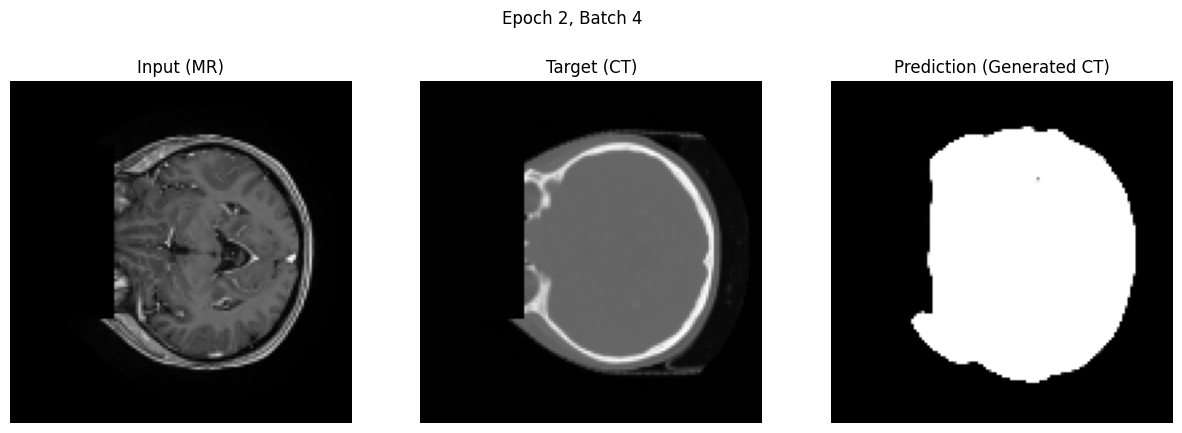

Epoch 3/10, Avg Validation Loss: 12218.6009, SSIM: -0.0000
EarlyStopping counter: 2 out of 5
Epoch [4/10], Step [1/63], D Loss: 0.0002, G Loss: 0.4833
Epoch [4/10], Step [11/63], D Loss: 0.0003, G Loss: 0.4840
Epoch [4/10], Step [21/63], D Loss: 0.0002, G Loss: 0.4846
Epoch [4/10], Step [31/63], D Loss: 0.0001, G Loss: 0.4850
Epoch [4/10], Step [41/63], D Loss: 0.0002, G Loss: 0.4857
Epoch [4/10], Step [51/63], D Loss: 0.0001, G Loss: 0.4865
Epoch [4/10], Step [61/63], D Loss: 0.0001, G Loss: 0.4866


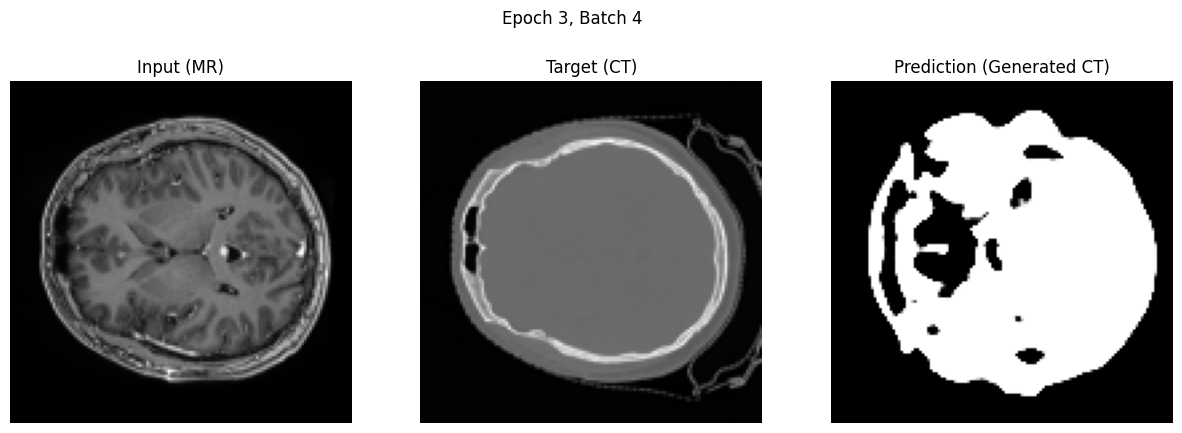

Epoch 4/10, Avg Validation Loss: 12205.7069, SSIM: -0.0000
EarlyStopping counter: 3 out of 5
Epoch [5/10], Step [1/63], D Loss: 0.0001, G Loss: 0.4864
Epoch [5/10], Step [11/63], D Loss: 0.0001, G Loss: 0.4875
Epoch [5/10], Step [21/63], D Loss: 0.0001, G Loss: 0.4884
Epoch [5/10], Step [31/63], D Loss: 0.0001, G Loss: 0.4884
Epoch [5/10], Step [41/63], D Loss: 0.0001, G Loss: 0.4881
Epoch [5/10], Step [51/63], D Loss: 0.0001, G Loss: 0.4884
Epoch [5/10], Step [61/63], D Loss: 0.0001, G Loss: 0.4895


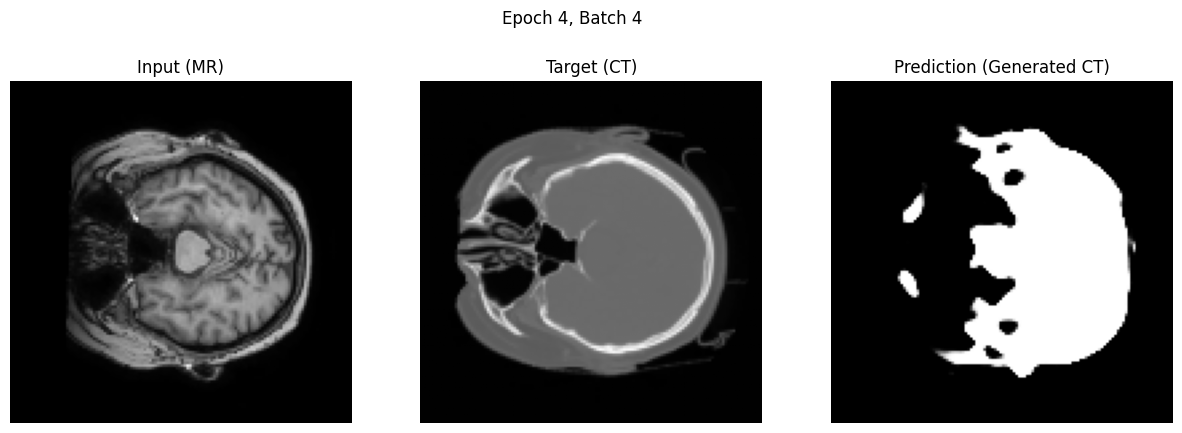

Epoch 5/10, Avg Validation Loss: 11681.2312, SSIM: -0.0000
EarlyStopping counter: 4 out of 5
Epoch [6/10], Step [1/63], D Loss: 0.0001, G Loss: 0.4897
Epoch [6/10], Step [11/63], D Loss: 0.0001, G Loss: 0.4900
Epoch [6/10], Step [21/63], D Loss: 0.0001, G Loss: 0.4895
Epoch [6/10], Step [31/63], D Loss: 0.0001, G Loss: 0.4900
Epoch [6/10], Step [41/63], D Loss: 0.0001, G Loss: 0.4901
Epoch [6/10], Step [51/63], D Loss: 0.0000, G Loss: 0.4908
Epoch [6/10], Step [61/63], D Loss: 0.0001, G Loss: 0.4911


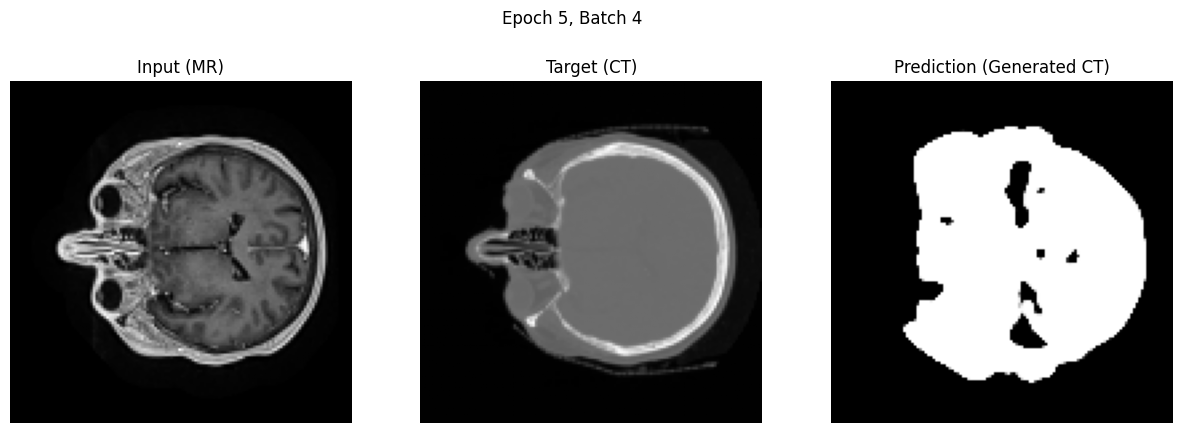

Epoch 6/10, Avg Validation Loss: 11313.3786, SSIM: -0.0000
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.


In [13]:
# Training Loop
from skimage.metrics import structural_similarity as ssim
import torch.nn.functional as F

# L2 Loss 來代替 BCELoss (Least Squares GAN (LSGAN))
def lsgan_loss(pred, target):
    return 0.5 * torch.mean((pred - target) ** 2)


def calculate_ssim(fake, real):
    # 確保數據形狀為 (N, C, D, H, W)
    fake_np = fake.squeeze(1).cpu().numpy()  # 去掉單通道 (C=1)
    real_np = real.squeeze(1).cpu().numpy()

    ssim_values = []
    for i in range(fake_np.shape[0]):  # 遍歷批次
        for d in range(fake_np.shape[1]):  # 遍歷深度維度
            ssim_value = ssim(
                fake_np[i, d], real_np[i, d], data_range=real_np[i, d].max() - real_np[i, d].min()
            )
            ssim_values.append(ssim_value)

    return sum(ssim_values) / len(ssim_values)  # 返回平均 SSIM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_gan(data_loader, val_loader, generator, discriminator, g_optimizer, d_optimizer, criterion, epochs=10, device='cuda'):
    generator.to(device)
    discriminator.to(device)

    early_stopping = EarlyStopping(patience=5, verbose=True, delta=0.00005, path="checkpoint.pt")

    for epoch in range(epochs):
        for i, (mr, ct) in enumerate(data_loader):
            mr, ct = mr.to(device), ct.to(device)

            # Train Discriminator
            real_output = discriminator(ct)
            fake_ct = generator(mr)
            fake_ct = torch.sigmoid(fake_ct)  # 保證範圍在 [0, 1]
            fake_output = discriminator(fake_ct.detach())

            # LSGAN 判別器損失
            d_loss_real = lsgan_loss(real_output, torch.ones_like(real_output))  # 真實樣本對應1
            d_loss_fake = lsgan_loss(fake_output, torch.zeros_like(fake_output))  # 假樣本對應0
            d_loss = (d_loss_real + d_loss_fake) / 2

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # Train Generator
            fake_output = discriminator(fake_ct)
            # LSGAN 生成器損失
            g_loss = lsgan_loss(fake_output, torch.ones_like(fake_output))  # 生成器希望判別器給 1

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(data_loader)}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

        # 可視化結果：每 5 個 epoch 執行一次
        random_idx = torch.randint(0, len(mr), (1,)).item()
        visualize_results(mr[random_idx:random_idx+1], ct[random_idx:random_idx+1], fake_ct[random_idx:random_idx+1], epoch, idx=4)

        # validation
        generator.eval()
        val_loss = 0.0
        ssim_score = 0.0  # Example for SSIM metric
        with torch.no_grad():
            for mr, ct in val_loader:
                mr, ct = mr.to(device), ct.to(device)
                fake_ct = generator(mr)
                loss = F.mse_loss(fake_ct, ct)  # 使用 MSE Loss 或 SSIM 作為附加度量
                val_loss += loss.item()
                ssim_score += calculate_ssim(fake_ct, ct)

        avg_val_loss = val_loss / len(val_loader)
        avg_ssim = ssim_score / len(val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Avg Validation Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}")

        # Early stopping
        early_stopping(avg_val_loss + (1 - avg_ssim), generator)

        if early_stopping.early_stop:
            print("Early stopping triggered. Stopping training.")
            break



# Main Script
if __name__ == "__main__":
    train_data = "/content/split/train"
    val_data = "/content/split/validation"
    test_data = "/content/split/test"
    train_set = MRCTDataset(train_data)
    val_set = MRCTDataset(val_data)
    val_loader = DataLoader(val_set, batch_size=2, shuffle=False)
    data_loader = DataLoader(train_set, batch_size=2, shuffle=True)

    generator = Generator()
    discriminator = Discriminator()

    criterion = nn.BCELoss()
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0005)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0005)

    # 嘗試從檢查點加載模型
    # start_epoch = 0
    # if os.path.exists("checkpoint.pt"):
    #     generator, g_optimizer, start_epoch, _ = load_checkpoint(generator, g_optimizer)
    #     discriminator, d_optimizer, _, _ = load_checkpoint(discriminator, d_optimizer)

    train_gan(data_loader, val_loader, generator, discriminator, g_optimizer, d_optimizer, criterion)


In [5]:
import torch

# Path to the checkpoint file
checkpoint_path = 'checkpoint.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

# Print the keys to see what data is inside the checkpoint
print("Checkpoint contains the following keys:")
for key in checkpoint.keys():
    print(key)

# Optionally, inspect the contents of specific keys (e.g., if you want to see 'epoch' or 'model_state_dict')
print("\nExample content of 'epoch':", checkpoint.get('epoch', 'Not Found'))
print("Example content of 'val_loss':", checkpoint.get('val_loss', 'Not Found'))


<ipython-input-5-cd11fe1e967d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


FileNotFoundError: [Errno 2] No such file or directory: 'checkpoint.pth'